In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import foxes
import foxes.variables as FV

# Data Paths
lidar_path = 'data/measurements/'
era5_path = 'data/reanalysis/'
turbines_existing_path = 'data/turbine-info/coordinates/existing/'
turbines_planned_future_path = 'data/turbine-info/coordinates/planned_future/'
turbines_planned_in_operation_before_2030_path = 'data/turbine-info/coordinates/planned_in_operation_before_2030/'
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
turbine_power_curves_path = 'data/turbine-info/power_curves/'

# Function to read and extract data from csv files
def read_csv(path):
    data = pd.read_csv(path)
    return data

In [4]:
# choose more or less data 
#choose only the year 2023
data = pd.read_csv('LT_corrected_buoy6.csv', index_col=0)
data.index = pd.to_datetime(data.index)
data_2023 = data[data.index.year == 2023].copy()

# Function to group by month and calculate the mean
def group_month_and_calc_mean(df):
    df.index = pd.to_datetime(df.index)
    df['year'] = df.index.year
    df_month_mean = df.groupby('year').mean()
    return df_month_mean

# daily_mean_data = data_2023.resample('D').mean()
# daily_mean_data
df_month_mean = group_month_and_calc_mean(data_2023)
df_month_mean

,long-term_WS150,long-term_WD150
year,,
2023,10.239453,206.499406


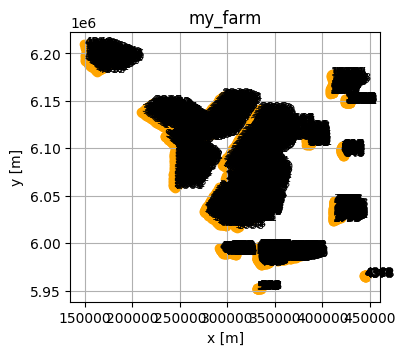

Calculating wind farm power for Combined_Cluster for Wake Model: ['Bastankhah2014_linear']:
[########################################] | 100% Completed | 107.04 ms
[########################################] | 100% Completed | 25.65 s
Efficiency added to farm results


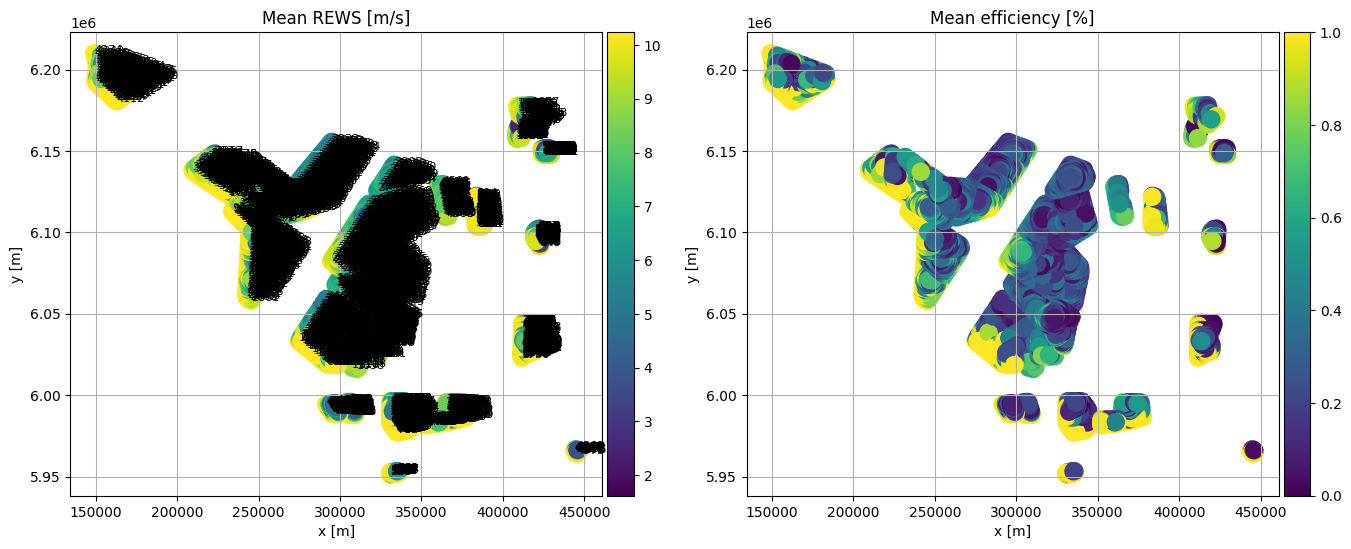

In [5]:
from Foxes_Farm_Power import Foxes_Farm_Power

# Paths
turbines_area_of_interest_path = 'data/turbine-info/coordinates/area_of_interest/'
external_farms_path = 'data/turbine-info/coordinates/existing_planned/'

# Read internal turbine layout files
internal_files = os.listdir(turbines_area_of_interest_path) # List all files in the directory
Turb_dfs = [pd.read_csv(turbines_area_of_interest_path + file) for file in internal_files]
Cluster_Turb_df = pd.concat(Turb_dfs, ignore_index=True)

# Read external turbine layout files
external_files = os.listdir(external_farms_path)
external_dfs = [pd.read_csv(external_farms_path + file) for file in external_files]
external_combined_df = pd.concat(external_dfs, ignore_index=True)

# Combine internal and external layouts for wake effect calculation
combined_df = pd.concat([Cluster_Turb_df, external_combined_df], ignore_index=True)
Combined_Turb_df = (combined_df, "Combined_Cluster")

# Define States using a valid data source
States = foxes.input.states.Timeseries(
    data_source= df_month_mean,
    output_vars=[FV.WS, FV.WD, FV.TI, FV.RHO],
    var2col={FV.WS: "long-term_WS150", FV.WD: "long-term_WD150", FV.TI: "time"},
    fixed_vars={FV.RHO: 1.225, FV.TI: 0.05},
)

# Define Parameters
Parameters = {
    'TType': "IEA15MW",
    'rotor_model': "centre",
    'wake_models': ["Bastankhah2014_linear"],
    'partial_wakes': None,
}

# Calculate the farm results with wake effects
combined_results = Foxes_Farm_Power(Combined_Turb_df, States, Parameters)

In [6]:
# Assuming combined_results contains the two DataFrames in a tuple
summary_results = combined_results[0]
turbine_results = combined_results[1]

# Display the summary results DataFrame
print("Summary Results:")
print(summary_results)

# Display the turbine results DataFrame
print("Turbine Results:")
print(turbine_results)

Summary Results:
                  Farm power [MW]  Farm ambient power [MW]  \
Combined_Cluster     23873.742513             63916.981803   

                  Farm efficiency [%]  Annual farm yield [TWh]  
Combined_Cluster            37.351173               209.133984  
Turbine Results:
             REWS             P              X             Y        YLD
turbine                                                                
0        3.469196    316.327989  293224.824041  6.040366e+06   2.771033
1        6.938021   4234.689847  291184.824041  6.036526e+06  37.095883
2        9.378599  10528.350838  288784.824041  6.032566e+06  92.228353
3        4.313105    856.129239  298024.824041  6.043846e+06   7.499692
4        7.691500   5820.193192  293944.824041  6.043486e+06  50.984892
...           ...           ...            ...           ...        ...
4830     4.788618   1252.707725  298294.591619  5.992610e+06  10.973720
4831     4.877374   1326.729722  298120.509700  5.993207e+06  1

In [11]:
# Extract the results for the farm of interest (Cluster_Turb_df)
matched_turbines = turbine_results.merge(Cluster_Turb_df, left_on=['X', 'Y'], right_on=['x', 'y'])

matched_turbines.drop(['x', 'y', 'index', 'id'] ,axis=1)

N9_farm_yield = (matched_turbines['YLD'].sum())/1000 #TWh 
print(f'Annual farm yield with external effects: {N9_farm_yield:.2f} TWh')

Annual farm yield with external effects: 12.34 TWh
